# Peak Sets and Genes

Using the links found using Cicero, look within peak sets to see if links are more likely within peak sets. Also try to link peaks/peak sets to genes.

In [5]:
library(cicero)
library(Matrix)
library(ggplot2)
library(scales)
library(GenomicFeatures)
library(reshape2)
library(rtracklayer)

Loading required package: monocle3

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignette

In [462]:
gz = "./out/20200529_k200_maxelem500_20200520_n68916_overlap_smallpeaks/coaccess.gt0.1.tsv.gz"
high_conns = read.table(gz, header=F, sep='\t')
colnames(high_conns) = c("Peak1", "Peak2", "coaccess")
high_conns$distance = abs(as.integer(lapply(strsplit(as.character(high_conns$Peak1), "_"), "[[", 2)) - as.integer(lapply(strsplit(as.character(high_conns$Peak2), "_"), "[[", 2)))
min(high_conns$coaccess)
dim(high_conns)
head(high_conns)

[1] 0.1

[1] 37974486        4

,Peak1,Peak2,coaccess,distance
,<fct>,<fct>,<dbl>,<int>
1,chr10_100000215_100000415,chr10_99749761_99750006,0.3785478,250454
2,chr10_100000215_100000415,chr10_99768506_99768737,0.2277071,231709
3,chr10_100000215_100000415,chr10_99768737_99768990,0.3100303,231478
4,chr10_100000215_100000415,chr10_99775997_99776219,0.1733493,224218
5,chr10_100000215_100000415,chr10_99776219_99776455,0.1706237,223996
6,chr10_100000215_100000415,chr10_99776645_99776893,0.2274022,223570


In [463]:
# filter by score 
high_conns = high_conns[high_conns$coaccess>0.2, ]

# filter by distance
# high_conns = high_conns[high_conns$distance>500, ]

In [622]:
dim(high_conns)

[1] 17522420        4

In [42]:
# choose = na.omit(high_conns[(high_conns$coaccess>0.25)&(high_conns$distance<1000), ])
# choose = choose[sample(dim(choose)[1]), ]
# dim(choose)
# head(choose)

## Prepare Promoters

In [6]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gencode.basic.tx.hg38 = subset(subset(gencode.basic.hg38, gene_type=="protein_coding"), type=="transcript")
head(gencode.basic.tx.hg38, 2)
length(gencode.basic.tx.hg38)

Warning message in readGFF(filepath, version = version, filter = filter):
"connection is not positioned at the start of the file, rewinding it"


GRanges object with 3 ranges and 21 metadata columns:
      seqnames        ranges strand |   source       type     score     phase
         <Rle>     <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1   65419-71585      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1   69055-70108      + |  ENSEMBL transcript      <NA>      <NA>
  [3]     chr1 450703-451697      - |   HAVANA transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
  [3] ENSG00000284733.1 protein_coding      OR4F29           2  HGNC:31275
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 

[1] 58073

In [122]:
tss.hg38 = unique(resize(gencode.basic.tx.hg38, width=1, fix='start'))
head(tss.hg38, 2)

GRanges object with 2 ranges and 21 metadata columns:
      seqnames    ranges strand |   source       type     score     phase
         <Rle> <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1     65419      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1     69055      + |  ENSEMBL transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 ENST00000641515.2  protein_coding       OR4F5-202
  [2] OTTHUMG00000001094.4 ENST00000335137.4  protein_coding       OR4F5-201
      transcript_support_level         tag

In [158]:
# for downstream analyses, allow co-accessibility to tss proximal enhancers
prom.hg38 = promoters(tss.hg38, upstream = 2000, downstream = 2000)
head(prom.hg38, 2)

GRanges object with 2 ranges and 21 metadata columns:
      seqnames      ranges strand |   source       type     score     phase
         <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1 63419-67418      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1 67055-71054      + |  ENSEMBL transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 ENST00000641515.2  protein_coding       OR4F5-202
  [2] OTTHUMG00000001094.4 ENST00000335137.4  protein_coding       OR4F5-201
      transcript_support_level    

## Visualize

In [9]:
gene_anno <- data.frame(gencode.basic.hg38)
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]


# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

In [10]:
dim(gene_anno)

[1] 1603274      30

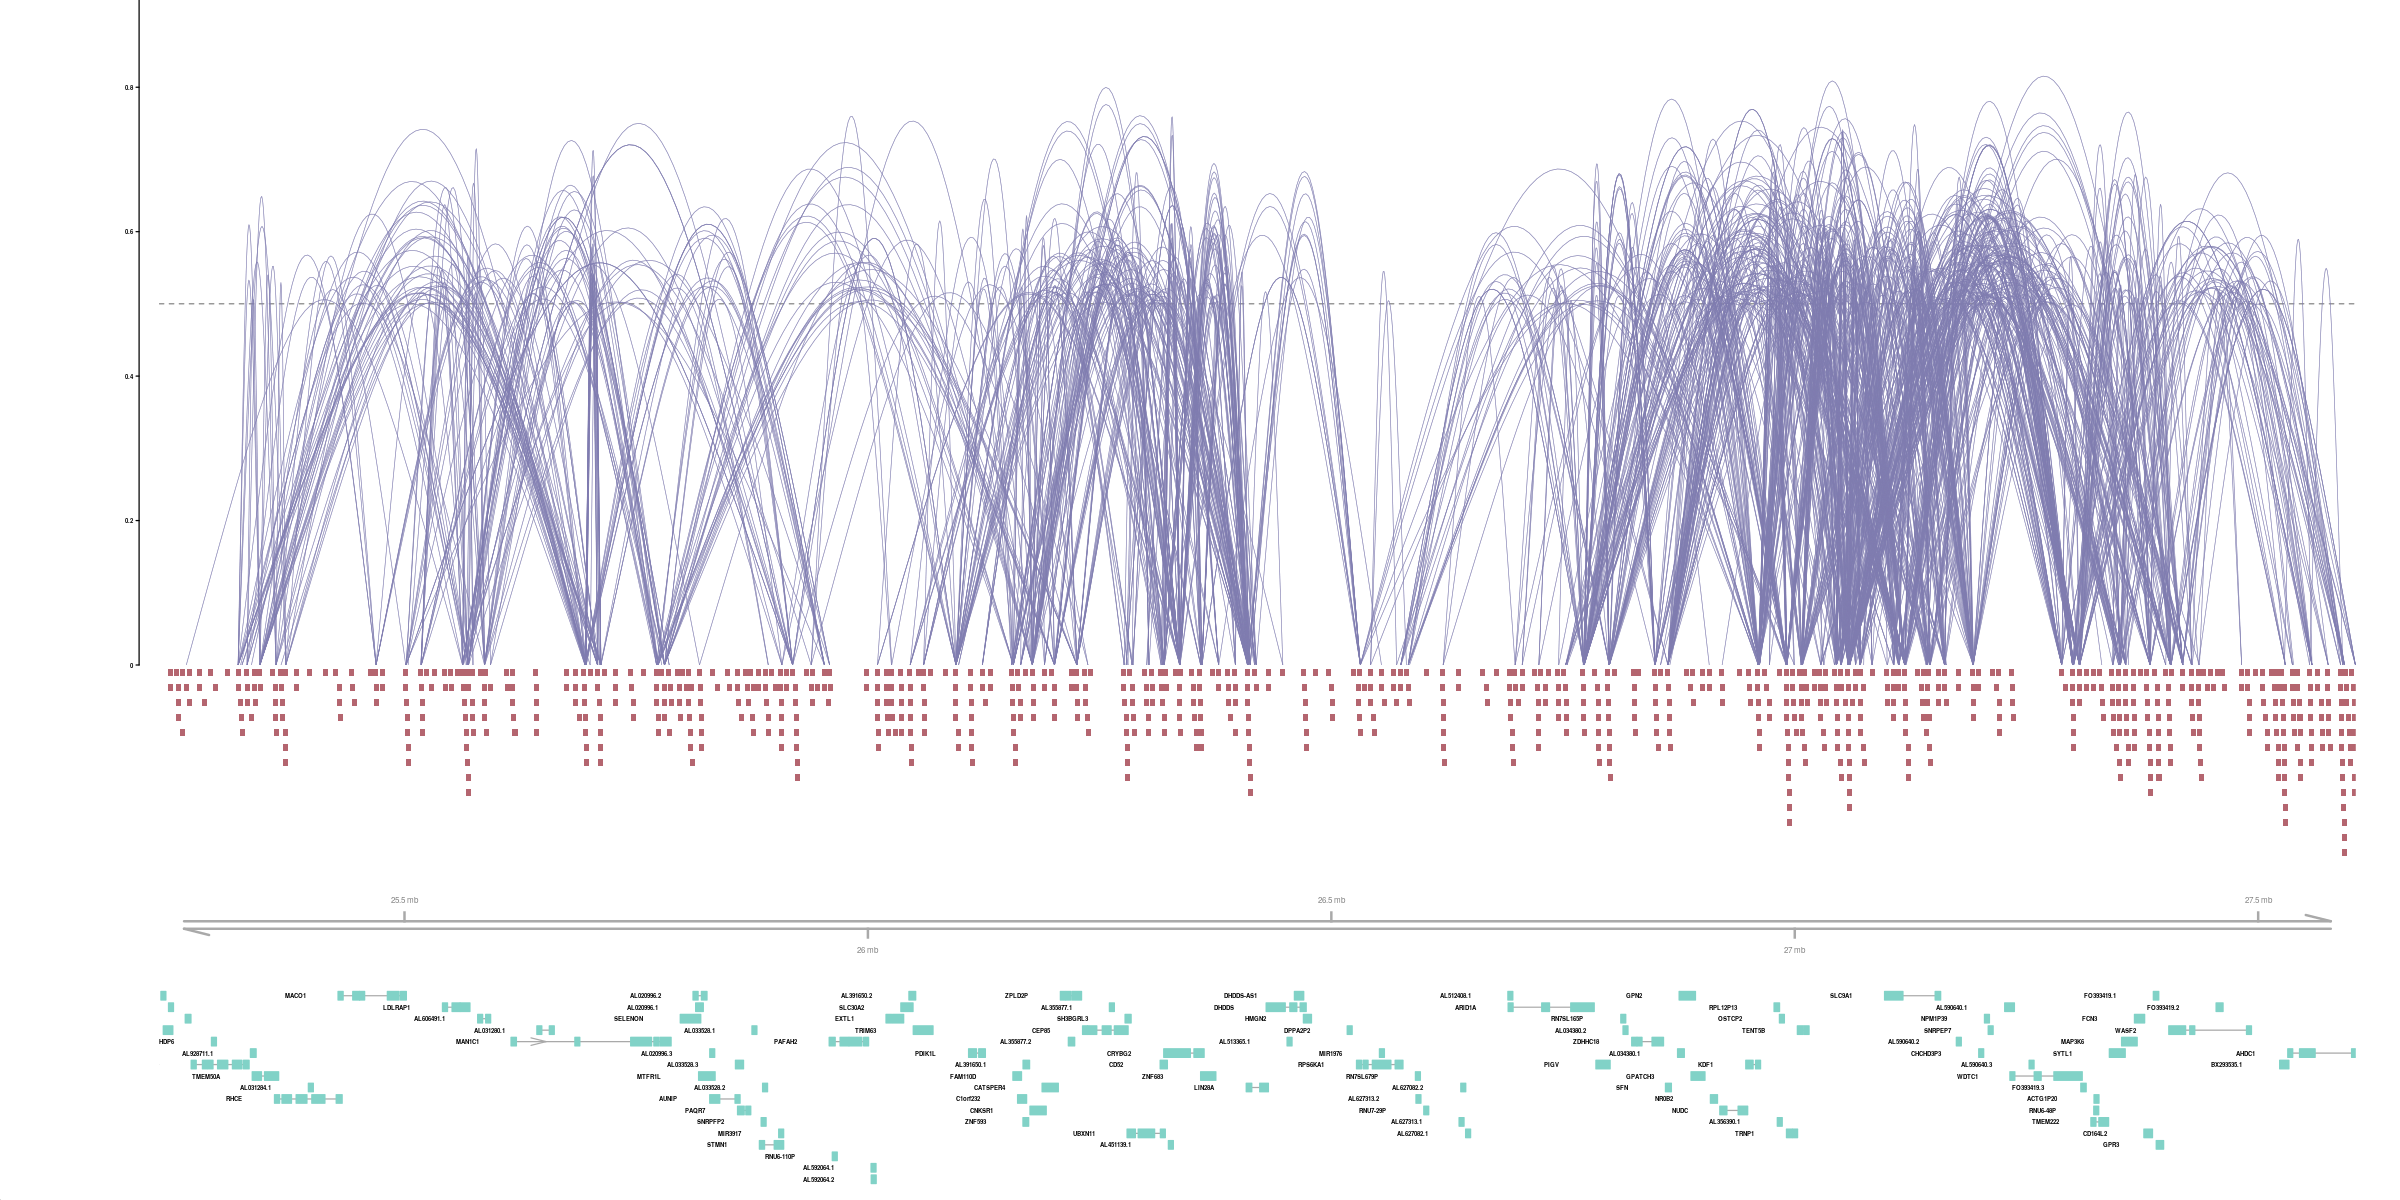

In [159]:
options(repr.plot.width = 20, repr.plot.height = 10)

plot_connections(high_conns[high_conns$distance>10000,], "chr1", 25235185, 27605310,
                 gene_model = gene_anno, 
                 coaccess_cutoff = .5, 
                 connection_width = .5, 
                 collapseTranscripts = "longest" )

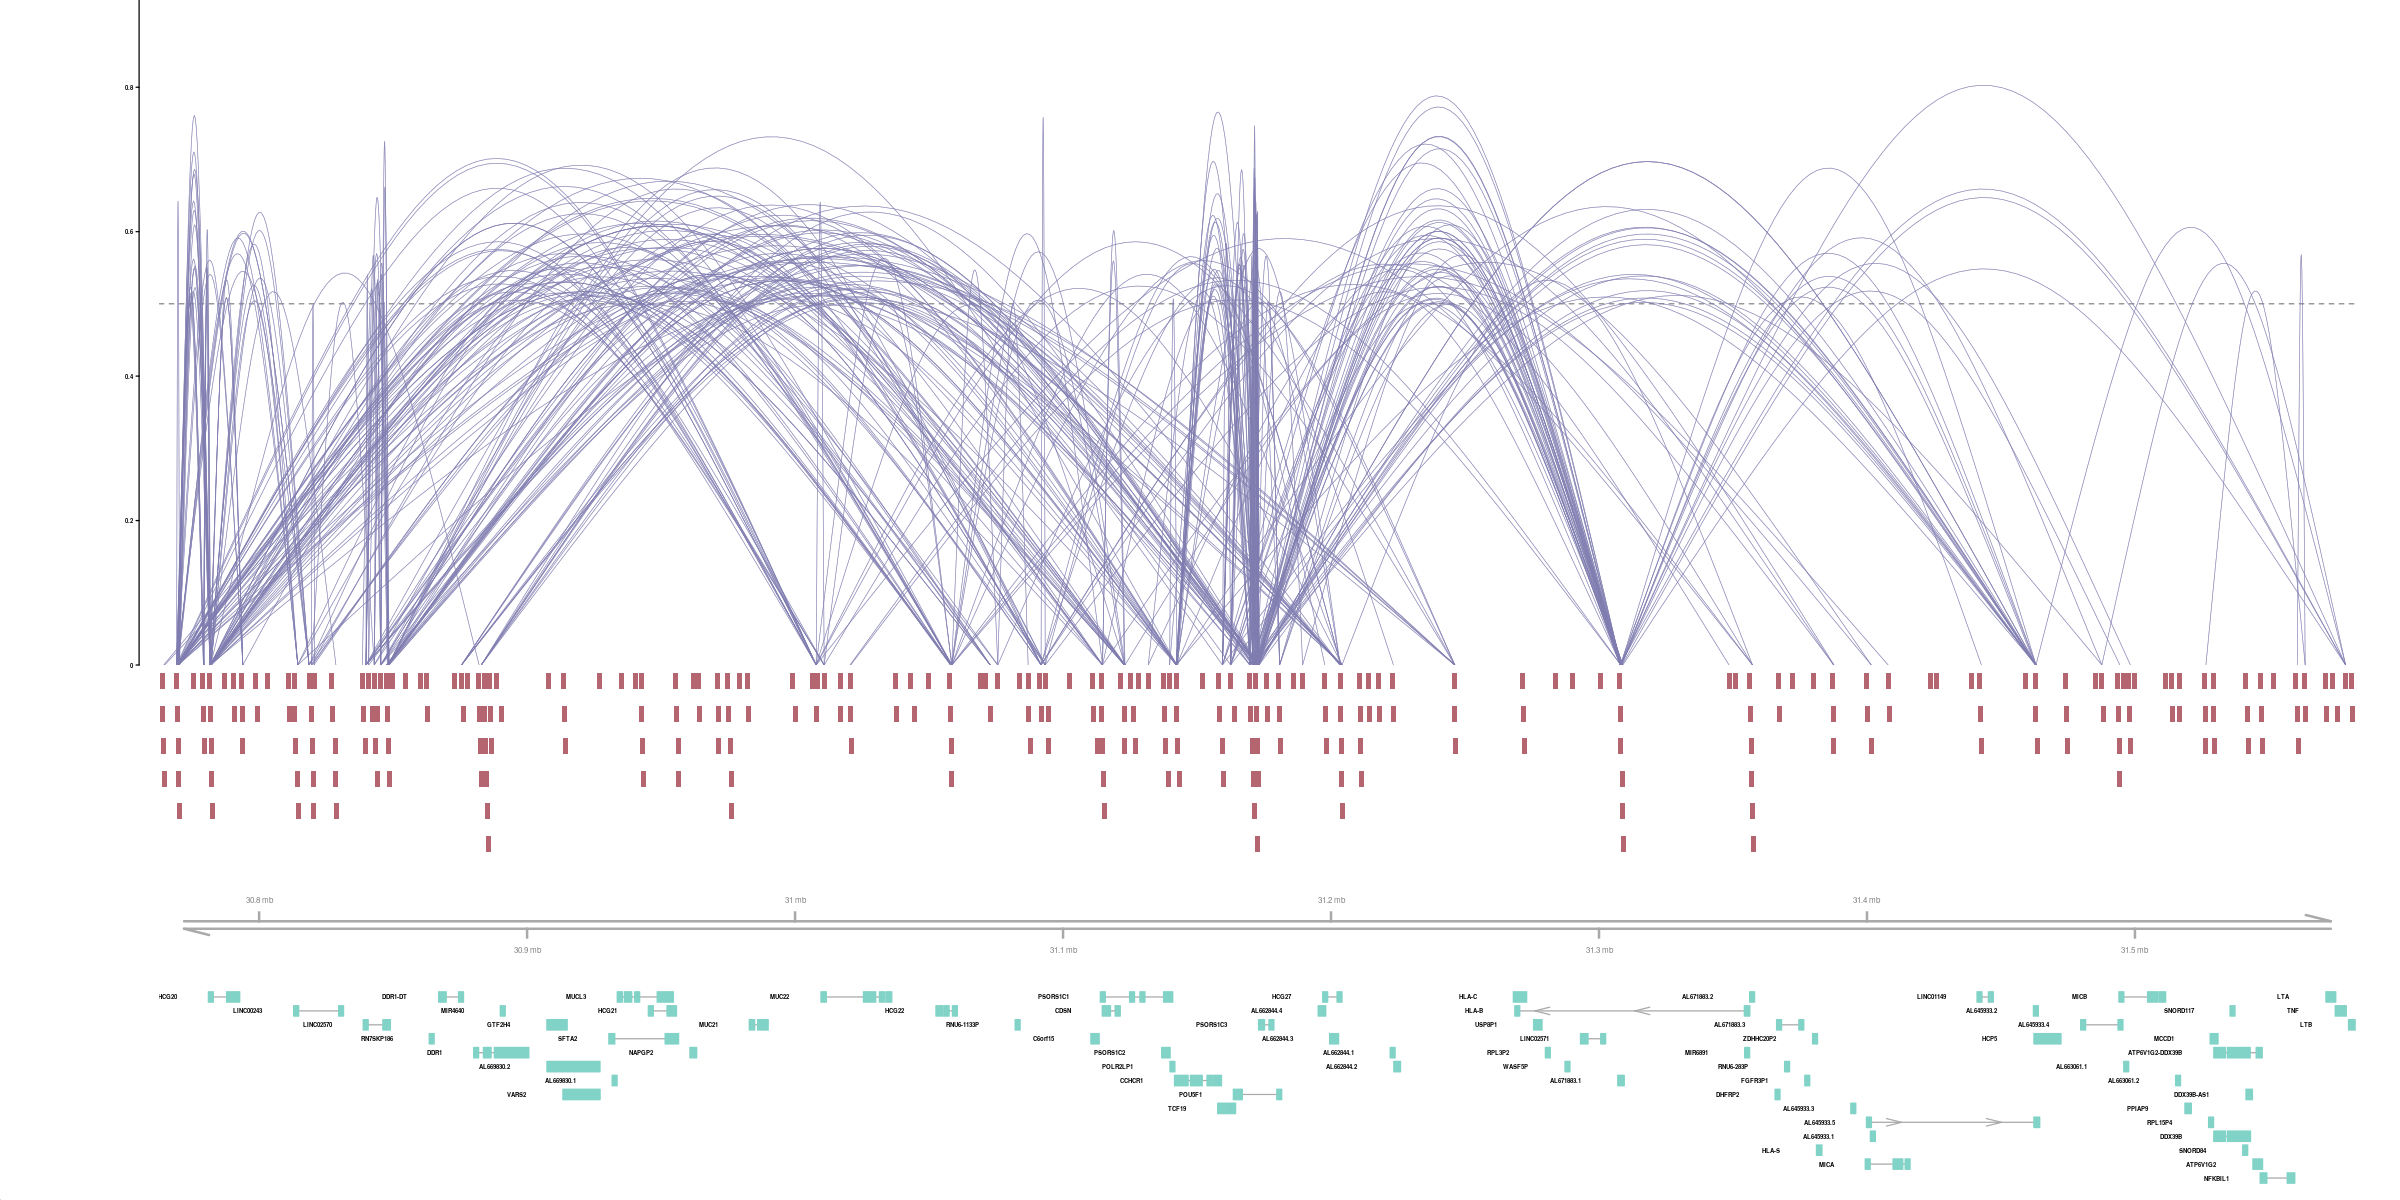

In [160]:
options(repr.plot.width = 20, repr.plot.height = 10)

# OCT4: "chr6", 30762659, 31582409
plot_connections(high_conns[high_conns$distance>1000,], "chr6", 30762659, 31582409,
#                  viewpoint = "chr2_209425462_209426064",
                 gene_model = gene_anno, 
                 coaccess_cutoff = .5, 
                 connection_width = .5, 
                 collapseTranscripts = "longest" )

## Peak Sets

In [465]:
peaks_left = sub("_", "-", sub("_", ":", high_conns$Peak1))
peaks_right = sub("_", "-", sub("_", ":", high_conns$Peak2))
head(peaks_left)
head(peaks_right)

[1] "chr10:100000215-100000415" "chr10:100000215-100000415"
[3] "chr10:100000215-100000415" "chr10:100000215-100000415"
[5] "chr10:100000215-100000415" "chr10:100000215-100000415"

[1] "chr10:99749761-99750006" "chr10:99768506-99768737"
[3] "chr10:99768737-99768990" "chr10:99776645-99776893"
[5] "chr10:99784410-99784710" "chr10:99790689-99790941"

In [466]:
length(high_conns$coaccess)

[1] 17522420

In [467]:
# looks like each connection is entered twice
all(sort(peaks_left)==sort(peaks_right))

[1] TRUE

In [468]:
peaks_left_is_gene = seq(1,length(peaks_left)) %in% queryHits(findOverlaps(GRanges(peaks_left), prom.hg38))
peaks_right_is_gene = seq(1,length(peaks_right)) %in% queryHits(findOverlaps(GRanges(peaks_right), prom.hg38))
sum(peaks_left_is_gene)
sum(peaks_right_is_gene)

[1] 2317364

[1] 2317364

In [738]:
BASE_PATH = "../20200307_fine_clustering/beds/20200530_gridmap_peakwidthnorm_n15/"
BEDS = c("idx3")

peak_set = data.frame(chr=c(), start=c(), end=c())
for (bed in BEDS) {
    cur_peak_set = read.table(sprintf("%s/%s.bed", BASE_PATH, bed))
    colnames(cur_peak_set) = c("chr", "start", "end")    
    
    peak_set = rbind(peak_set, cur_peak_set)
}

peak_set = paste(paste(peak_set$chr, peak_set$start, sep=":"), peak_set$end, sep='-')
head(peak_set)

[1] "chr1:46255150-46255350"   "chr1:14486447-14486667"  
[3] "chr1:208220808-208221008" "chr1:206898291-206898494"
[5] "chr1:27544782-27544982"   "chr1:55916494-55916794"

---
**STRICT OVERLAP** (if peak set == high_conns peaks)

In [739]:
peaks_left_overlaps_peak_set = peaks_left %in% peak_set
peaks_right_overlaps_peak_set = peaks_right %in% peak_set
sum(peaks_left_overlaps_peak_set)
sum(peaks_right_overlaps_peak_set)

[1] 1626796

[1] 1626796

---
Less strict overlap

In [740]:
# peaks_left_overlaps_peak_set = seq(1,length(peaks_left)) %in% queryHits(findOverlaps(GRanges(peaks_left), 
#                                                                                      GRanges(peak_set),
#                                                                                     minoverlap=200))
# peaks_right_overlaps_peak_set = seq(1,length(peaks_right)) %in% queryHits(findOverlaps(GRanges(peaks_right), 
#                                                                                        GRanges(peak_set),
#                                                                                       minoverlap=200))
# sum(peaks_left_overlaps_peak_set)
# sum(peaks_right_overlaps_peak_set)

---

In [741]:
length(peak_set)

[1] 57784

In [742]:
length(unique(peaks_left[peaks_left_overlaps_peak_set]))

[1] 54251

In [743]:
# find enhancer/non-promoter -> gene links such that enhancer belongs to set
# can look from left to right only since each link is repeated twice 
enhancer_to_gene_link = (peaks_left_overlaps_peak_set&(!peaks_left_is_gene)&(peaks_right_is_gene)) #&(high_conns$distance>10000))
e2g_overlaps = findOverlaps(GRanges(peaks_right[enhancer_to_gene_link]), prom.hg38)
e2g_enhs = peaks_left[enhancer_to_gene_link][queryHits(e2g_overlaps)] # these are the enhancers that link to gene
e2g_genes = prom.hg38[subjectHits(e2g_overlaps)]$gene_name
e2g_transcripts = prom.hg38[subjectHits(e2g_overlaps)]$transcript_name
e2g_uniq = unique(data.frame(e=e2g_enhs, g=e2g_genes)) # uniquify e-g link
e2gt_uniq = unique(data.frame(e=e2g_enhs, gtx=e2g_transcripts)) # uniquify e-g:tx link

# look at 5kb bins that are linked to gene, instead of #enhancers (which can be nearby)
# note that coaccess links are within choromosomes only, so do not need to identify chr in bin
b2g_uniq = unique(data.frame(b=as.integer(start(GRanges(e2g_uniq$e))/5000),  # break into 5kb bins
                             g=e2g_uniq$g)) # uniquify bin-gene link
b2gt_uniq = unique(data.frame(b=as.integer(start(GRanges(e2gt_uniq$e))/5000),  # break into 5kb bins
                             gtx=e2gt_uniq$g)) # uniquify bin-g:tx link
sum(enhancer_to_gene_link)
length(unique(e2g_uniq$e))
length(unique(e2g_uniq$g))
length(unique(e2gt_uniq$gtx))

[1] 117573

[1] 25340

[1] 7152

[1] 17468

In [744]:
# cor(table(e2g_uniq$g), table(b2g_uniq$g), method='spearman')

In [745]:
# rev(sort(table(b2g_uniq$g)))[1:50]
rev(sort(table(b2gt_uniq$gtx)))[1:50]
# rev(sort(table(e2g_genes)))[200]


     FOXL1-201      FOXF1-201      FOXC2-201      RUNX1-207      RUNX1-201 
            53             53             48             44             44 
   SPATA13-206      RUNX1-202   C1QTNF9B-202   C1QTNF9B-201 AL359736.1-201 
            42             42             42             42             42 
     RUNX1-205      NR3C1-209      NR3C1-205      NR3C1-204      NR3C1-203 
            41             40             40             40             40 
     NR3C1-201       NAV2-204        TNC-202       TBX2-201     COL6A3-209 
            40             40             38             38             38 
    COL6A3-205     COL6A3-203     COL6A3-201    TNFSF15-202        TNC-210 
            38             38             38             37             37 
      NAV2-216       NAV2-201       TLN2-202    STARD13-204     SLC1A2-240 
            37             37             36             36             36 
    SLC1A2-231     SLC1A2-223     MICAL2-201      TRIB1-201       MLPH-204 
           

In [746]:
e2g_uniq[grepl("^POU5F1$", e2g_uniq$g),]

e,g
<fct>,<fct>


In [749]:
Q = "TERT"
Q %in% unique(e2g_uniq$g)
table(e2g_uniq$g)[Q]

[1] FALSE

<NA> 
  NA

In [1676]:
# high_conns[enhancer_to_gene_link,][unique(queryHits(findOverlaps(GRanges(peaks_right[enhancer_to_gene_link]), prom.hg38[prom.hg38$gene_id=="MYCN"]))),]

In [681]:
# all peaks that are coaccessible with this set of peaks
links_part_of = peaks_left_overlaps_peak_set # don't need right as each link appears twice
peaks_touched = unique(c(peaks_left[links_part_of], peaks_right[links_part_of], peak_set))

In [682]:
length(peaks_touched)
head(peaks_touched)

[1] 276594

[1] "chr10:100038297-100038503" "chr10:100038503-100038758"
[3] "chr10:100146437-100146737" "chr10:100146765-100147065"
[5] "chr10:100149151-100149366" "chr10:10020992-10021254"

In [683]:
# all genes touch
genes_touched = unique(prom.hg38[unique(queryHits(findOverlaps(prom.hg38, GRanges(peaks_touched))))]$gene_name)
length(genes_touched)

[1] 10433

In [684]:
"JAKMIP2" %in% genes_touched

[1] TRUE

In [685]:
# set of genes that simply intersects with peak set
genes_in_peak_set = prom.hg38[queryHits(findOverlaps(prom.hg38, GRanges(peak_set)))]$gene_name
length(table(genes_in_peak_set))

[1] 1484

In [686]:
head(rev(sort(table(genes_in_peak_set))))

genes_in_peak_set
  IL32    LSR DGLUCY  STMN2   ADD2  ABCB8 
    44     40     27     25     20     18 

In [1686]:
length(unique(subjectHits(findOverlaps(prom.hg38, GRanges(peak_set)))))

[1] 512

In [1687]:
'TRIM2' %in% genes_in_peak_set

[1] FALSE

In [1711]:
sum(table(b2g_uniq$g)>1)

[1] 3566

In [1690]:
length(intersect(genes_touched, names(table(b2g_uniq$g))))
length(intersect(names(table(b2g_uniq$g)), names(table(genes_in_peak_set))))
length(intersect(genes_touched, names(table(genes_in_peak_set))))

[1] 1836

[1] 294

[1] 451

In [1694]:
length(rev(sort(table(c(genes_in_peak_set, as.character(e2g_uniq$g))))))

[1] 1993

In [1776]:
length(table(b2g_uniq$g)[table(b2g_uniq$g)>=2])

[1] 3214

In [751]:
TMP_PATH = "tmp.txt"
genes_to_write = unique(sub("-2[0-9]+", "", names(rev(sort(table(b2gt_uniq$gtx)[table(b2gt_uniq$gtx)>=2])))))[1:5000]

fileConn = file(TMP_PATH)
writeLines(unique(genes_to_write), fileConn)
close(fileConn)

In [1523]:
TMP_PATH = "tmp_touched.txt"
genes_to_write = genes_touched

fileConn = file(TMP_PATH)
writeLines(unique(genes_to_write), fileConn)
close(fileConn)

In [2754]:
TMP_PATH = "tmp_ordered.txt"
genes_to_write = unique(c(names(rev(sort(table(b2g_uniq$g)))), genes_touched))

fileConn = file(TMP_PATH)
writeLines(unique(c(genes_to_write, sample(unique(prom.hg38$gene_name)))), fileConn)
close(fileConn)

In [ ]:
TMP_PATH = "tmp_all.txt"
fileConn = file(TMP_PATH)
writeLines(unique(prom.hg38$gene_id), fileConn)
close(fileConn)

## mRNA analysis

From Cachiarelli et al 2015

In [32]:
# load bulk RNA-seq data
fpkm = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm$gene_id = NULL
fpkm$locus=NULL
tpm = fpkm
tpm[,2:ncol(tpm)] = 1e6*t(t(tpm[,2:ncol(tpm)])/colSums(tpm[,2:ncol(tpm)]))

# removing genes with dup names
tpm = tpm[!duplicated(tpm$gene_short_name),]
rownames(tpm) = tpm$gene_short_name
tpm$gene_short_name = NULL

tpm["GAPDH",]

,hiF.T_P14,X2dd_DOX_plus,X5dd_DOX_plus,X8dd_DOX_plus,X10dd_DOX_plus_SSEA3_pos,X14dd_DOX_plus_SSEA3_pos,X20dd_DOX_plus_TRA_plus,X24dd_TRA_pos_DOX_plus,X24dd_TRA_pos_DOX_minus,hIPSC.T_P10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAPDH,7803.64,4963.505,3908.693,3839.776,3795.548,3364.503,3032.412,3790.955,5598.224,4731.256


In [617]:
# how many genes have increased/decreased expr in iPSC?
sum(tpm[, 1]<tpm[, 10])/dim(tpm)[1]
sum(tpm[, 1]>tpm[, 10])/dim(tpm)[1]

[1] 0.4084688

[1] 0.2534418

In [752]:
# gene_set_to_plot = names(rev(sort(table(e2g_uniq$g)[table(e2g_uniq$g)>=5])))[1:50]
# gene_set_to_plot = names(rev(sort(table(b2g_uniq$g)[table(b2g_uniq$g)>=10])))[1:100]
gene_set_to_plot = unique(sub("-2[0-9]+", "", names(rev(sort(table(b2gt_uniq$gtx)[table(b2gt_uniq$gtx)>=2])))))
# gene_set_to_plot = names(rev(sort(table(genes_in_peak_set))))[1:100]
# gene_set_to_plot = genes_touched
# gene_set_to_plot = names(rev(sort(genes_in_peak_set)))[1:50]

In [753]:
# filter to those that have >1 TPM at any time point
gene_set_to_plot = gene_set_to_plot[gene_set_to_plot %in% rownames(tpm)]
gene_set_to_plot = gene_set_to_plot[rowMaxs(as.matrix(tpm[gene_set_to_plot, ]))>1]

gene_set_to_plot = gene_set_to_plot[1:100]

length(gene_set_to_plot)

[1] 100

In [754]:
# how many have increased/decreased expression?
sum(tpm[gene_set_to_plot, 1]<tpm[gene_set_to_plot, 10])/length(gene_set_to_plot)
sum(tpm[gene_set_to_plot, 1]>tpm[gene_set_to_plot, 10])/length(gene_set_to_plot)

[1] 0.18

[1] 0.82

In [755]:
colMedians(as.matrix(log2(1+tpm)[gene_set_to_plot, ]))

[1] 4.965815 3.965623 2.989819 3.150938 3.374435 3.263388 2.534043 2.200952
 [9] 2.605601 2.430321

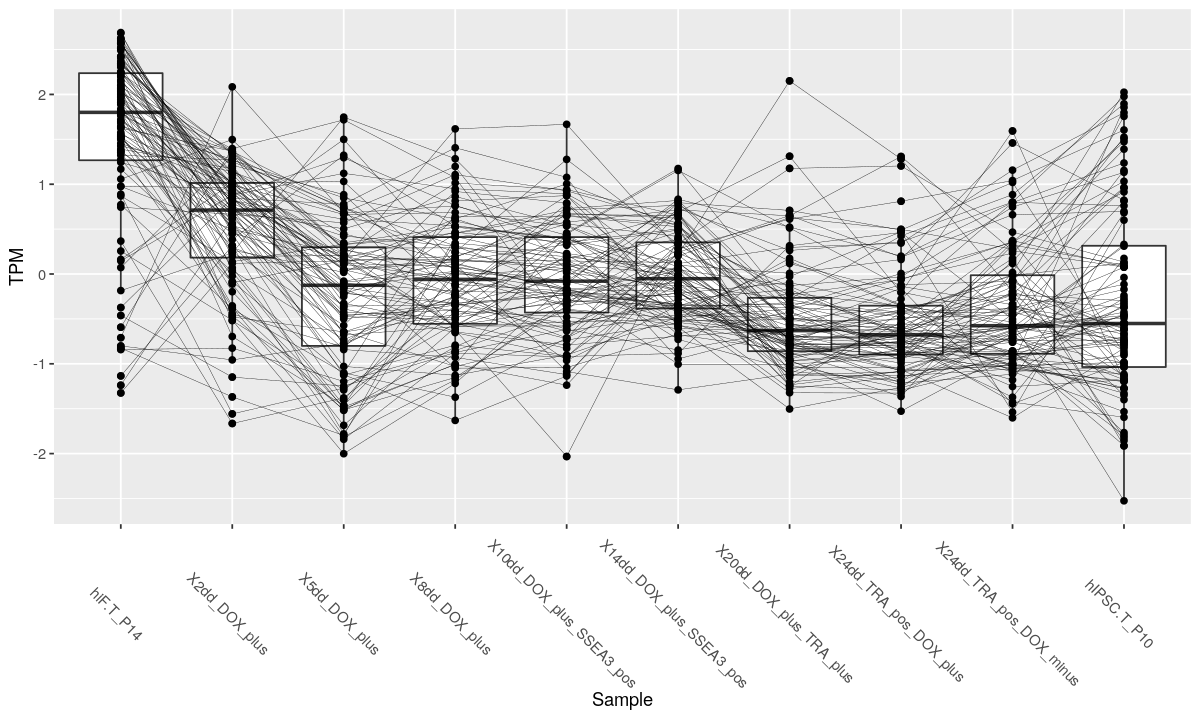

In [756]:
options(repr.plot.width = 10, repr.plot.height = 6)

# ggplot(melt(as.matrix(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ])), aes(x=Var2, y=value)) +
ggplot(melt(t(scale(t(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ])))), aes(x=Var2, y=value)) +
stat_boxplot() +
geom_line(aes(group=Var1),size=0.1) + geom_point() +
theme(axis.text.x = element_text(angle = -45)) +
ylab("TPM") + xlab("Sample")
# geom_boxplot(outlier.shape = NA) + geom_jitter(width = 0.2)
# coord_cartesian(ylim=c(0,8)) 

In [288]:
TFs = as.character(read.table("../../../resources/FANTOM5/tf.txt")$V1)
length(TFs)

[1] 1672

In [289]:
colnames(tpm)

[1] "hiF.T_P14"                "X2dd_DOX_plus"           
 [3] "X5dd_DOX_plus"            "X8dd_DOX_plus"           
 [5] "X10dd_DOX_plus_SSEA3_pos" "X14dd_DOX_plus_SSEA3_pos"
 [7] "X20dd_DOX_plus_TRA_plus"  "X24dd_TRA_pos_DOX_plus"  
 [9] "X24dd_TRA_pos_DOX_minus"  "hIPSC.T_P10"

In [356]:
filtered_gene_set = names(rev(sort(table(b2g_uniq$g)[table(b2g_uniq$g)>=10])))

# peak is early
# filtered_gene_set = filtered_gene_set[rowMaxs(as.matrix(tpm[filtered_gene_set,]))==rowMaxs(as.matrix(tpm[filtered_gene_set,c("X2dd_DOX_plus", "X5dd_DOX_plus", "X8dd_DOX_plus")]))]

# peak is early-mid
# filtered_gene_set = filtered_gene_set[rowMaxs(as.matrix(tpm[filtered_gene_set,]))==rowMaxs(as.matrix(tpm[filtered_gene_set,c("X2dd_DOX_plus", "X5dd_DOX_plus", "X8dd_DOX_plus", 
#                                                                                                                             "X10dd_DOX_plus_SSEA3_pos")]))]

# peak is late
filtered_gene_set = filtered_gene_set[rowMaxs(as.matrix(tpm[filtered_gene_set,]))==rowMaxs(as.matrix(tpm[filtered_gene_set,c('X20dd_DOX_plus_TRA_plus',
                                                                                                                             'X24dd_TRA_pos_DOX_plus',
                                                                                                                             'X24dd_TRA_pos_DOX_minus',
                                                                                                                             'hIPSC.T_P10')]))]


# >1 TPM at some time point
filtered_gene_set = filtered_gene_set[rowMaxs(as.matrix(tpm[filtered_gene_set,]))>10]

# Fib Expression
filtered_gene_set = filtered_gene_set[(tpm[filtered_gene_set,1]<10)] 

# iPSC Expression
filtered_gene_set = filtered_gene_set[(tpm[filtered_gene_set,10]>10)] 

# filter to TFs
filtered_gene_set = filtered_gene_set[filtered_gene_set %in% TFs]

filtered_gene_set = filtered_gene_set[!is.na(filtered_gene_set)]

for (x in filtered_gene_set) {
    cat(sprintf("%s\n", x))
}

MYCN
PRDM14
ZNF320
ZSCAN18
ZNF732
ZNF160
ZFP42
ZSCAN10
ZNF398
ZNF253


## g:Profiler

In [651]:
library(gprofiler2)

In [652]:
gostres = gost(genes_to_write, 
              organism="hsapiens",
              ordered_query=T)

In [695]:
filtered_res = gostres$result[gostres$result$source=="GO:BP", c(4,5,6,12, 10,11,3), ]
filtered_res$enrichment = (filtered_res$intersection_size/filtered_res$query_size)/(filtered_res$term_size/filtered_res$effective_domain_size)
head(filtered_res[rev(order(filtered_res$enrichment)), ], 20)

,term_size,query_size,intersection_size,effective_domain_size,source,term_name,p_value,enrichment
,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
55,37,125,5,17906,GO:BP,regulation of chromatin silencing,0.013275555,19.357838
66,10,628,5,17906,GO:BP,DNA cytosine deamination,0.027068468,14.256369
30,12,628,6,17906,GO:BP,cytidine to uridine editing,0.003337933,14.256369
36,13,628,6,17906,GO:BP,pyrimidine ribonucleoside catabolic process,0.006015049,13.159726
50,14,628,6,17906,GO:BP,pyrimidine ribonucleoside metabolic process,0.010214135,12.219745
25,12,921,7,17906,GO:BP,hemidesmosome assembly,0.001398847,11.341115
52,21,628,7,17906,GO:BP,ribonucleoside catabolic process,0.011377535,9.504246
33,16,2073,10,17906,GO:BP,negative regulation of neuron projection regeneration,0.004170434,5.398577
60,29,1722,12,17906,GO:BP,keratan sulfate biosynthetic process,0.015653761,4.302775


## Misc Analysis of Whether Peak at TSS Implies Expression and so on

In [23]:
peak_set = read.table(gzfile("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bulk/croo/iPSC/peak/overlap_reproducibility/overlap.optimal_peak.narrowPeak.gz"))
colnames(peak_set) = c("chr", "start", "end")
peak_set = paste(paste(peak_set$chr, peak_set$start, sep=":"), peak_set$end, sep='-')
head(peak_set)

[1] "chr1:100034561-100034806" "chr1:100037558-100039065"
[3] "chr1:100037558-100039065" "chr1:100037558-100039065"
[5] "chr1:100037558-100039065" "chr1:100037558-100039065"

In [1467]:
gene_overlap_tss = unique(tss.hg38[queryHits(findOverlaps(tss.hg38, GRanges(peak_set)))]$gene_name)
gene_overlap_prom = unique(tss.hg38[queryHits(findOverlaps(promoters(tss.hg38, upstream=2000, downstream=500), GRanges(peak_set)))]$gene_name)

In [31]:
gene_not_overlap_tss = setdiff(tss.hg38$gene_name, gene_overlap_tss)
gene_not_overlap_prom = setdiff(tss.hg38$gene_name, gene_overlap_prom)
gene_overlap_prom_not_tss = setdiff(gene_overlap_prom, gene_overlap_tss)

In [32]:
gene_overlap_tss_in_rna = gene_overlap_tss[gene_overlap_tss %in% rownames(tpm)]
gene_overlap_prom_in_rna = gene_overlap_prom[gene_overlap_prom %in% rownames(tpm)]

gene_not_overlap_tss_in_rna = gene_not_overlap_tss[gene_not_overlap_tss %in% rownames(tpm)]
gene_not_overlap_prom_in_rna = gene_not_overlap_prom[gene_not_overlap_prom %in% rownames(tpm)]

gene_overlap_prom_not_tss_in_rna = gene_overlap_prom_not_tss[gene_overlap_prom_not_tss %in% rownames(tpm)]

length(gene_overlap_tss_in_rna)
length(gene_overlap_prom_in_rna)
length(gene_not_overlap_tss_in_rna)
length(gene_not_overlap_prom_in_rna)
length(gene_overlap_prom_not_tss_in_rna)

[1] 13789

[1] 14555

[1] 3651

[1] 2885

[1] 766

In [34]:
sum(tpm[gene_overlap_tss_in_rna, 10]>1)/length(gene_overlap_tss_in_rna)
sum(tpm[gene_overlap_prom_in_rna, 10]>1)/length(gene_overlap_prom_in_rna)
sum(tpm[gene_not_overlap_tss_in_rna, 10]>1)/length(gene_not_overlap_tss_in_rna)
sum(tpm[gene_not_overlap_prom_in_rna, 10]>1)/length(gene_not_overlap_prom_in_rna)
sum(tpm[gene_overlap_prom_not_tss_in_rna, 10]>1)/length(gene_overlap_prom_not_tss_in_rna)

[1] 0.828559

[1] 0.7975953

[1] 0.1268146

[1] 0.09670711

[1] 0.2402089